In [1]:
import numpy
from matplotlib import pyplot
import py_monte_carlo
from scipy import sparse
import scipy.sparse.linalg
import scipy.linalg
import pickle
import os

In [2]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = sparse.dok_matrix((2**nvars,2**nvars), dtype=numpy.float64)
    
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        
        for j in range(nvars):
            i_flip = i ^ (1 << j)
            ham[i, i_flip] = ham[i, i_flip] + transverse
    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = sparse.diags(spin_diag)
    return ham.tocsc(), spin_op.tocsc()

In [3]:
def make_lattice(x_side, y_side,j=1.0):
    nvars = x_side*y_side

    x = numpy.arange(x_side)
    y = numpy.arange(y_side)
    X, Y = numpy.meshgrid(x, y)

    INDX = Y*x_side + X
    RIGHT = Y*x_side + (X+1)%x_side
    BOT = (((Y+1) % y_side )*x_side + X)

    right_edges = [((a, b), 1.0 if (y%2 == 0) else -1.0) for a, b, x, y in zip(INDX.flatten(), RIGHT.flatten(), X.flatten(), Y.flatten())]
    bot_edges = [((a, b), -1.0) for a, b in zip(INDX.flatten(), BOT.flatten())]

    edges =  right_edges + bot_edges
    edge_list = numpy.asarray([(a, b) for ((a, b),_) in edges])
    edge_values = numpy.asarray([j for _, j in edges])
    
    nvars = numpy.max(edge_list) + 1
    return nvars, edges

def make_lattice_faces(x_side, y_side):
    def f(x, y):
        return (y%y_side)*x_side + (x%x_side)
    def make_face(x, y):
        return [f(x,y), f(x+1,y), f(x+1,y+1), f(x,y+1)]
    return [make_face(x, y) for x in range(x_side) for y in range(y_side)]
    
def plot_graph(edges, x_side, y_side):
    for (a,b),j in edges:
        c = 'b'
        if j > 0:
            c = 'r'
        ax = a % x_side
        ay = a // x_side
        bx = b % x_side
        by = b // x_side
        if abs(bx - ax) <= 1 and abs(by - ay) <= 1: 
            pyplot.plot([ax, bx], [ay, by], c)
        else:
            pyplot.plot([ax, bx], [ay, by], c, alpha=0.1)
    pyplot.show()

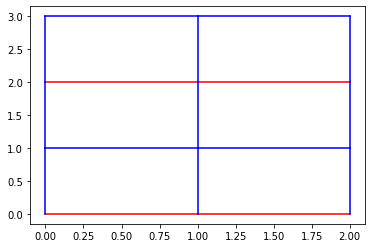

In [4]:
nx = 3
ny = 4
nvars, edges = make_lattice(nx, ny)
faces = make_lattice_faces(nx, ny)
plot_graph(edges, nx, ny)

In [5]:
betas = 10**numpy.linspace(-1,numpy.log10(3), 10)
transverse = 0.2

In [6]:
graph = py_monte_carlo.Lattice(edges)
graph.set_transverse_field(transverse)
# graph.set_enable_semiclassical_update(True)
graph.enable_semiclassical_loops_from_vars(faces)

In [7]:
q_transverse_data = numpy.zeros(len(betas))
q_transverse_std = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results, energies = graph.run_quantum_monte_carlo_and_measure_spins(beta, 50000, 16, exponent=2, sampling_wait_buffer=10000)
    q_transverse_data[i] = numpy.mean(results, axis=0)
    q_transverse_std[i] = numpy.std(results, axis=0)

In [8]:
saved_data_filename = "testsemiclassicalloop_ed.pickle"
if os.path.exists(saved_data_filename):
    with open(saved_data_filename, "rb") as f:
        ed_transverse_data = pickle.load(f)
else:
    ed_transverse_data = []
    ham, spin_op = make_ham_and_spin(nvars, edges, transverse)
    for beta in betas:
        expm = scipy.sparse.linalg.expm(-beta*ham)
        ed_transverse_data.append((spin_op @ expm).diagonal().sum() / (expm).diagonal().sum())
    with open(saved_data_filename, "wb") as w:
        pickle.dump(ed_transverse_data, w)

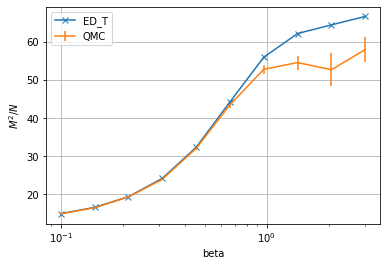

In [9]:
pyplot.plot(betas, ed_transverse_data, 'x-', label="ED_T")
pyplot.errorbar(betas, q_transverse_data, q_transverse_std, label="QMC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.xlabel("beta")
pyplot.ylabel("$M^2/N$")
pyplot.show()